In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import re
import pickle
from gensim.models import word2vec
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tempfile
import subprocess
import matplotlib.pyplot as plt 

RandomSeed = 42
np.random.seed(RandomSeed)


pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)
sns.set(font_scale = 1.2)

AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']



def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    
    return entropy


def extract_LCR(seq):
    tmp_LCR = tempfile.NamedTemporaryFile()  
    with open(tmp_LCR.name, 'w') as f_LCR:
         f_LCR.write('>1\n' + str(seq))
    tmp_LCR.seek(0)
    
    out = subprocess.Popen(['segmasker', '-in', str(tmp_LCR.name)], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_LCR, stderr_LCR = out.communicate() 
    stdout_LCR = stdout_LCR.split()[1:]
    
    LCR_start_values = []; LCR_end_values = []    
    for i in range(0, int(len(stdout_LCR)/3)):
        LCR_start_values.append(int(str(stdout_LCR[3*i],'utf-8')))
        LCR_end_values.append(int(str(stdout_LCR[3*i + 2],'utf-8')))
    LCR_residues = []
    for i in range(0, len(LCR_start_values)):
        LCR_residues.extend(list(np.linspace(LCR_start_values[i], LCR_end_values[i], (LCR_end_values[i] - LCR_start_values[i] + 1) )))
    LCR_residues = sorted(list(set(LCR_residues)))
    LCR_sequence = ''
    for i in range(0, len(LCR_residues)):
        LCR_sequence = LCR_sequence + seq[int(LCR_residues[i]-1)]
        
    return len(LCR_residues), LCR_sequence


def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    #IDR_seq = AAs[IDR_residues].str.cat()
    
    return len(IDR_residues)#, IDR_seq


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count


def phys_features(sequence):
   # Evaluate sequence specific parameters that the model uses:
    df = pd.DataFrame({'Sequence' : [sequence]})
    df['Sequence_length'] = df['Sequence'].str.len()
    df['Hydrophobicity'] = hydrophobicity(str(df['Sequence']))
    df['Shannon_entropy'] = Shannon_entropy(str(df['Sequence'])) 
    LCR_reg = extract_LCR(df['Sequence'].item())
    df['LCR_fragments']  = LCR_reg[1]
    df['LCR_length'] = LCR_reg[0]
    df['LCR_fraction']  = LCR_reg[0] / df['Sequence_length']
    IDR_reg = extract_IDR(df['Sequence'].item())
    #df['IDR_sequence']  = IDR_reg[1]
    df['IDR_fraction']  = IDR_reg / df['Sequence_length']
    
    # and also the amino acid composition specific features that the model uses:
    for k in range(0, len(AA_array)):
        df['AA_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['Sequence']]
    df['Polar'] = 0; df['Cation'] = 0; df['Arom'] = 0;df['Polar_LCR']=0;
    for i in range(0, len(Polar_AAs)):
        df['Polar']  = df['Polar']  + df['AA_' + str(Polar_AAs[i])]
    for i in range(0, len(Arom_AAs)):
        df['Arom']  = df['Arom']  + df['AA_' + str(Arom_AAs[i])]
    for i in range(0, len(Cation_AAs)):
        df['Cation']  = df['Cation']  + df['AA_' + str(Cation_AAs[i])]
    for k in range(0, len(AA_array)):
        df['AA_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['LCR_fragments']]
    for i in range(0, len(Polar_AAs)):
        df['Polar_LCR']  = df['Polar_LCR']  + df['AA_' + str(Polar_AAs[i])]
    
    df = df.loc[:,~df.columns.str.startswith('AA_')]
    df['Polar_frac'] = (df['Polar']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Cation_frac'] = (df['Cation']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Arom_frac'] = (df['Arom']  / df["Sequence_length"] ).replace(np.nan, 0)
    df['Polar_frac_LCR']=(df['Polar_LCR']/df['LCR_length']).replace(np.nan,0)
  
    
    df = df.drop(columns={'Polar', 'Arom', 'Cation', 'LCR_fragments', 'Polar_LCR', 'LCR_length'})
    
    return df



In [2]:
true_llps = pd.read_csv('LLPS_sequences_final.csv')
true_llps=true_llps[(true_llps['Category'] == 'LLPS_easy')]
true_llps=true_llps.rename(columns={"Uniprot_ID": "Entry"})
true_llps.index=true_llps['Entry']
true_llps=true_llps.drop(['LLPS?', 'Category', 'Unnamed: 0', 'Entry', 'Full_length', 'Construct_length', 'Full_sequence'], axis=1)
true_llps

,Construct_sequence
Entry,
D0PV95,MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGQNTRWNNLDAPPSRGTSKWENRGARDERIEQELFSGQLSGINFDKYEEIPVEATGDDVPQPISLFSDLSLHEWIEENIKTAGYDRPTPVQKYSIPALQGGRDLMSCAQTGSGKTAAFLVPLVNAILQDGPDAVHRSVTSSGGRKKQYPSALVLSPTRELSLQIFNESRKFAYRTPITSALLYGGRENYKDQIHKLRLGCHILIATPGRLIDVMDQGLIGMEGCRYLVLDEADRMLDMGFEPQIRQIVECNRMPSKEERITAMFSATFPKEIQLLAQDFLKENYVFLAVGRVGSTSENIMQKIVWVEEDEKRSYLMDLLDATGDSSLTLVFVETKRGASDLAYYLNRQNYEVVTIHGDLKQFEREKHLDLFRTGTAPILVATAVAARGLDIPNVKHVINYDLPSDVDEYVHRIGRTGRVGNVGLATSFFNDKNRNIARELMDLIVEANQELPDWLEGMSGDMRSGGGYRGRGGRGNGQRFGGRDHRYQGGSGNGGGGNGGGGGFGGGGQRSGGGGGFQSGGGGGRQQQQQQRAQPQQDWWS
D0PV95,MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGQNTRWNNLDAPPSRGTSKWENRGARDERIEQELFSGQLSGINFDKYEEIPVEATGDDVPQPISLFSDLSLHEWIEENIKTAGYDRPTPVQKYSIPALQGGRDLMSCAQTGSGKTAAFLVPLVNAILQDGPDAVHRSVTSSGGRKKQYPSALVLSPTRELSLQIFNESRKFAYRTPITSALLYGGRENYKDQIHKLRLGCHILIATPGRLIDVMDQGLIGMEGCRYLVLDEADRMLDMGFEPQIRQIVECNRMPSKEERITAMFSATFPKEIQLLAQDFLKENYVFLAVGRVGSTSENIMQKIVWVEEDEKRSYLMDLLDATGDSSLTLVFVETKRGASDLAYYLNRQNYEVVTIHGDLKQFEREKHLDLFRTGTAPILVATAVAARGLDIPNVKHVINYDLPSDVDEYVHRIGRTGRVGNVGLATSFFNDKNRNIARELMDLIVEANQELPDWLEGMSGDMRSGGGYRGRGGRGNGQRF
D0PV95,ESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDG
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGG
...,...
P10636-8,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIE
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGF
P08908,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAAIALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCCTSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPEDRSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADTRHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGNSKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLPFFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFCRQ


In [3]:
true_llps.index

Index(['D0PV95', 'D0PV95', 'D0PV95', 'P35637', 'P35637', 'P39936', 'P35637',
       'P35637', 'P35637', 'P35637',
       ...
       'P35637', 'P78953', 'P10636-8', 'P10636-8', 'P10636-8', 'P10636-8',
       'P35637', 'P08908', 'Q41372', 'E1UZH7'],
      dtype='object', name='Entry', length=137)

In [4]:
sequences = true_llps['Construct_sequence'].tolist()

In [5]:
temp_c = [phys_features(t) for t in sequences]
temp_c_df = pd.concat(temp_c)
temp_c_df.index = true_llps.index
temp_c_df = temp_c_df.drop(['Sequence'], axis=1)
temp_c_df

,Sequence_length,Hydrophobicity,Shannon_entropy,LCR_fraction,IDR_fraction,Polar_frac,Cation_frac,Arom_frac,Polar_frac_LCR
Entry,,,,,,,,,
D0PV95,708,-591.7,3.864046,0.274011,0.413842,0.436441,0.135593,0.077684,0.664948
D0PV95,647,-498.3,3.889436,0.225657,0.315301,0.404946,0.139104,0.077280,0.602740
D0PV95,167,-292.9,2.634421,0.736527,1.005988,0.586826,0.149701,0.071856,0.601626
P35637,526,-698.3,3.398065,0.678707,0.899240,0.657795,0.102662,0.098859,0.756303
P35637,501,-640.6,3.369530,0.700599,0.894212,0.672655,0.091816,0.099800,0.760684
...,...,...,...,...,...,...,...,...,...
P10636-8,129,-90.1,3.278849,0.000000,0.480620,0.449612,0.201550,0.015504,0.000000
P35637,494,-629.6,3.381825,0.694332,0.888664,0.672065,0.089069,0.101215,0.763848
P08908,422,78.1,3.934198,0.026066,0.063981,0.355450,0.118483,0.085308,0.090909


In [6]:
with open('nw.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

In [7]:
exs = pd.read_excel('uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.xlsx')
exs.index = exs['Entry']
exs = exs.drop(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Status', 'Gene ontology (biological process)', 'Gene ontology (cellular component)', 'Gene ontology (molecular function)', 'Gene ontology (GO)', 'Gene ontology IDs'], axis=1)


In [8]:
df4=exs.loc[mynewlist]
test_seq = df4['Sequence'].tolist()
test = [phys_features(t) for t in test_seq]
test_df = pd.concat(test)
test_df.index = df4.index
test_df = test_df.drop(['Sequence'], axis=1)
#test_df.style.bar(align='mid', color=['red', 'lightgreen'])
test_df

,Sequence_length,Hydrophobicity,Shannon_entropy,LCR_fraction,IDR_fraction,Polar_frac,Cation_frac,Arom_frac,Polar_frac_LCR
Entry,,,,,,,,,
O15116,133,-48.8,3.427337,0.000000,0.000000,0.263158,0.157895,0.045113,0.000000
O43561,262,-115.9,3.656444,0.312977,0.648855,0.423664,0.072519,0.061069,0.365854
O43663,620,-447.4,3.936272,0.059677,0.246774,0.324194,0.170968,0.056452,0.378378
O43791,374,-95.5,3.921510,0.045455,0.000000,0.310160,0.136364,0.090909,0.058824
O43809,227,-94.1,3.775225,0.000000,0.000000,0.352423,0.140969,0.114537,0.000000
...,...,...,...,...,...,...,...,...,...
Q9Y333,95,-15.0,3.324463,0.000000,0.000000,0.305263,0.136842,0.084211,0.000000
Q9Y4Y9,91,3.2,3.239256,0.000000,0.000000,0.351648,0.087912,0.032967,0.000000
Q9Y4Z0,139,-108.2,3.509798,0.302158,0.388489,0.417266,0.187050,0.050360,0.595238


In [9]:
with open('work.pkl', 'rb') as f:
    mynewlist1 = pickle.load(f)
df5=exs.loc[mynewlist1]
wtest_seq = df5['Sequence'].tolist()

wtest = [phys_features(t) for t in wtest_seq]
wtest_df = pd.concat(wtest)
wtest_df.index = df5.index
wtest_df = wtest_df.drop(['Sequence'], axis=1)
wtest_df

,Sequence_length,Hydrophobicity,Shannon_entropy,LCR_fraction,IDR_fraction,Polar_frac,Cation_frac,Arom_frac,Polar_frac_LCR
Entry,,,,,,,,,
O00401,505,-426.2,3.846972,0.316832,0.704950,0.465347,0.134653,0.053465,0.631250
O14641,736,-421.3,3.911254,0.317935,0.464674,0.449728,0.119565,0.063859,0.594017
O15169,862,-688.6,4.007694,0.104408,0.548724,0.370070,0.172854,0.062645,0.333333
O15550,1401,-647.5,4.096787,0.062099,0.336188,0.434690,0.122769,0.072805,0.494253
O43390,633,-594.8,3.950264,0.268562,0.325434,0.368088,0.161137,0.099526,0.482353
...,...,...,...,...,...,...,...,...,...
Q9UKY1,873,-678.8,4.020538,0.168385,0.320733,0.395189,0.145475,0.065292,0.414966
Q9ULX6,646,-666.0,3.968106,0.332817,0.380805,0.399381,0.139319,0.082043,0.474419
Q9UPQ9,1833,-1765.9,3.942577,0.173486,0.833606,0.565194,0.098745,0.058920,0.663522


In [18]:
with open('all.pkl', 'rb') as f:
    mynewlist2 = pickle.load(f)
df6=exs.loc[mynewlist2]
test_all = df6['Sequence'].tolist()

test = [phys_features(t) for t in test_all]
test_all = pd.concat(test)
test_all.index = df6.index
test_all = test_all.drop(['Sequence'], axis=1)
test_all

,Sequence_length,Hydrophobicity,Shannon_entropy,LCR_fraction,IDR_fraction,Polar_frac,Cation_frac,Arom_frac,Polar_frac_LCR
Entry,,,,,,,,,
O00401,505,-426.2,3.846972,0.316832,0.704950,0.465347,0.134653,0.053465,0.631250
O14641,736,-421.3,3.911254,0.317935,0.464674,0.449728,0.119565,0.063859,0.594017
O15116,133,-48.8,3.427337,0.000000,0.000000,0.263158,0.157895,0.045113,0.000000
O15169,862,-688.6,4.007694,0.104408,0.548724,0.370070,0.172854,0.062645,0.333333
O15550,1401,-647.5,4.096787,0.062099,0.336188,0.434690,0.122769,0.072805,0.494253
...,...,...,...,...,...,...,...,...,...
Q9Y3R0,1128,-413.2,4.013700,0.056738,0.137411,0.398936,0.132979,0.049645,0.359375
Q9Y4Y9,91,3.2,3.239256,0.000000,0.000000,0.351648,0.087912,0.032967,0.000000
Q9Y4Z0,139,-108.2,3.509798,0.302158,0.388489,0.417266,0.187050,0.050360,0.595238


In [20]:
test_all[test_all.index=='Q14974']



,Sequence_length,Hydrophobicity,Shannon_entropy,LCR_fraction,IDR_fraction,Polar_frac,Cation_frac,Arom_frac,Polar_frac_LCR
Entry,,,,,,,,,
Q14974,876,-84.6,4.022479,0.026256,0.0,0.321918,0.100457,0.061644,0.130435


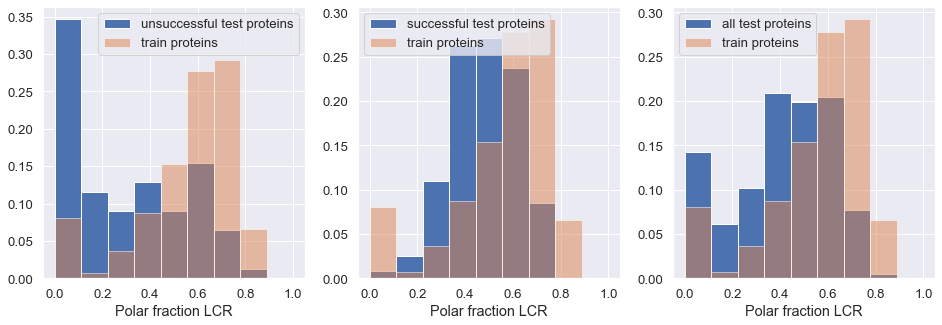

In [11]:
fig, ax = plt.subplots(1, 3, squeeze=False, figsize = (16,5))

bins=np.linspace(0,1,10)

ax[0][0].hist([test_df['Polar_frac_LCR']], bins, weights=np.ones(len(test_df['Polar_frac_LCR'])) / len(test_df['Polar_frac_LCR']), alpha=1, label='unsuccessful test proteins')
ax[0][0].hist([temp_c_df['Polar_frac_LCR']], bins, weights=np.ones(len(temp_c_df['Polar_frac_LCR'])) / len(temp_c_df['Polar_frac_LCR']), alpha=0.5, label='train proteins')
ax[0][0].legend(loc='upper right')
ax[0][0].set_xlabel('Polar fraction LCR')

ax[0][1].hist([wtest_df['Polar_frac_LCR']], bins, weights=np.ones(len(wtest_df['Polar_frac_LCR'])) / len(wtest_df['Polar_frac_LCR']),alpha=1, label='successful test proteins')
ax[0][1].hist([temp_c_df['Polar_frac_LCR']], bins, weights=np.ones(len(temp_c_df['Polar_frac_LCR'])) / len(temp_c_df['Polar_frac_LCR']),alpha=0.5, label='train proteins')
ax[0][1].legend(loc='upper left')
ax[0][1].set_xlabel('Polar fraction LCR')

ax[0][2].hist([test_all['Polar_frac_LCR']], bins, weights=np.ones(len(test_all['Polar_frac_LCR'])) / len(test_all['Polar_frac_LCR']), alpha=1, label='all test proteins')
ax[0][2].hist([temp_c_df['Polar_frac_LCR']], bins, weights=np.ones(len(temp_c_df['Polar_frac_LCR'])) / len(temp_c_df['Polar_frac_LCR']), alpha=0.5, label='train proteins')
ax[0][2].legend(loc='upper left')
ax[0][2].set_xlabel('Polar fraction LCR')

plt.show()